<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/rds_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install oandapyV20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=10385e700c9fc5a521fac0d7425ec74aa90c5e04c563fac18d137629d102157f
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


In [6]:
!pip install TA-Lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.6/369.6 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (TA-Lib)


In [7]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


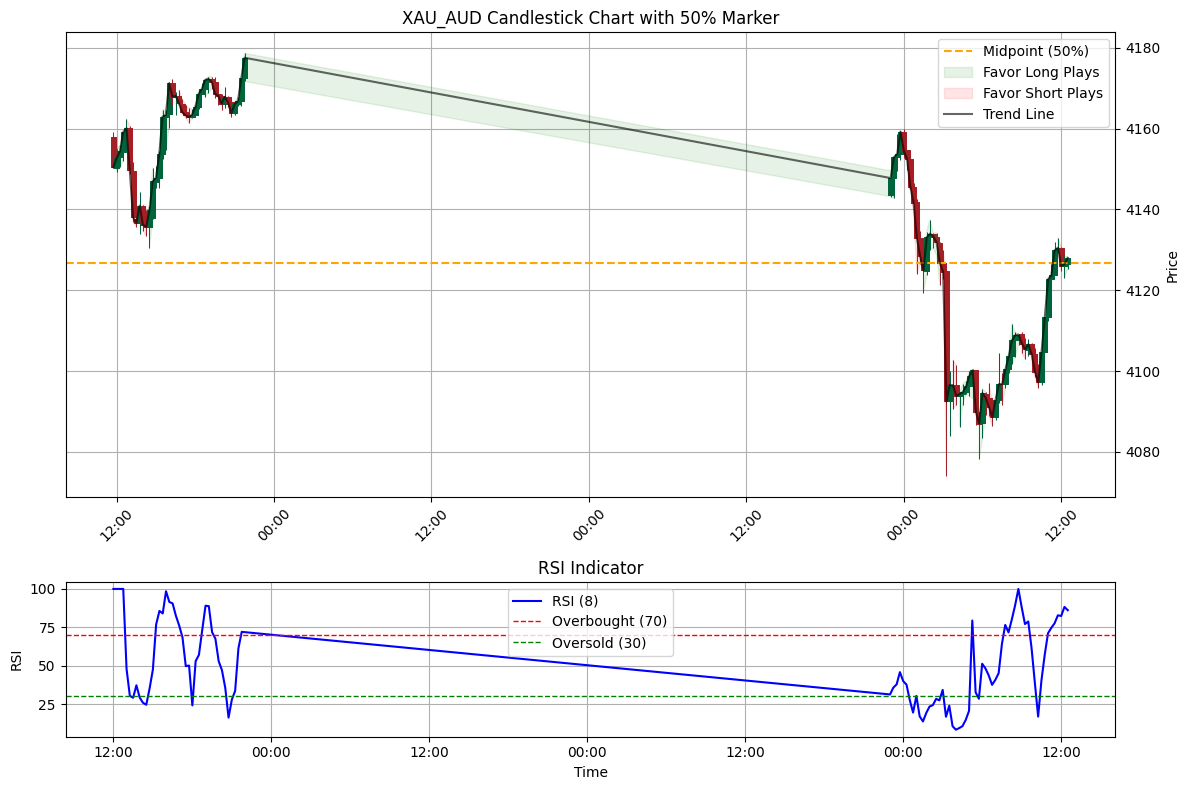

In [14]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num
import mplfinance as mpf

# OANDA API Configuration
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
INSTRUMENT = 'XAU_AUD'  # Replace with the desired trading pair
GRANULARITY = 'M15'  # 'D' for daily candlesticks
CLIENT = oandapyV20.API(access_token=ACCESS_TOKEN)






# Step 1: Fetch 15-Minute Candlestick Data
def fetch_candles(instrument, granularity, count=100):
    params = {
        "count": count,
        "granularity": granularity
    }
    endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
    CLIENT.request(endpoint)
    candles = endpoint.response['candles']
    data = [{
        'time': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c'])
    } for candle in candles]
    return pd.DataFrame(data)

# Step 2: Calculate Midpoint and RSI
def calculate_rsi(df, period=8):
    """
    Calculate RSI manually.
    """
    df['delta'] = df['close'].diff()
    df['gain'] = np.where(df['delta'] > 0, df['delta'], 0)
    df['loss'] = np.where(df['delta'] < 0, -df['delta'], 0)

    # Calculate rolling averages of gain and loss
    df['avg_gain'] = df['gain'].rolling(window=period, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window=period, min_periods=1).mean()

    # Calculate RSI
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['RSI'] = 100 - (100 / (1 + df['rs']))
    return df

def calculate_indicators(df):
    """
    Calculate 50% midpoint and RSI.
    """
    df['time'] = pd.to_datetime(df['time'])
    df['midpoint'] = (df['high'] + df['low']) / 2  # 50% marker
    df = calculate_rsi(df, period=8)
    return df

# Step 3: Plot Candlestick Chart with Midpoint and RSI
def visualize(df):
    # Set up figure and axes
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Convert to OHLC tuple for mplfinance
    df['date_num'] = date2num(df['time'])
    ohlc = df[['date_num', 'open', 'high', 'low', 'close']].values

    # Candlestick chart
    mpf.plot(
        df.set_index('time'),
        type='candle',
        ax=ax1,
        style='charles',
        show_nontrading=True,
    )

    # Plot 50% midpoint
    ax1.axhline(y=df['midpoint'].iloc[-1], color='orange', linestyle='--', linewidth=1.5, label='Midpoint (50%)')

    # Labeling Favor Long/Short zones
    ax1.fill_between(
        df['time'], df['low'], df['high'], where=(df['close'] > df['midpoint']),
        color='green', alpha=0.1, label='Favor Long Plays'
    )
    ax1.fill_between(
        df['time'], df['low'], df['high'], where=(df['close'] <= df['midpoint']),
        color='red', alpha=0.1, label='Favor Short Plays'
    )

    # Add trend line (optional)
    ax1.plot(df['time'], df['close'], color='black', alpha=0.6, label='Trend Line')

    # Chart labels
    ax1.set_title(f"{INSTRUMENT} Candlestick Chart with 50% Marker")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot RSI
    ax2.plot(df['time'], df['RSI'], label='RSI (8)', color='blue')
    ax2.axhline(y=70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
    ax2.set_title("RSI Indicator")
    ax2.set_ylabel("RSI")
    ax2.set_xlabel("Time")
    ax2.legend()
    ax2.grid(True)

    # Format date axis
    date_format = DateFormatter("%H:%M")
    ax1.xaxis.set_major_formatter(date_format)
    ax2.xaxis.set_major_formatter(date_format)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Main Workflow
if __name__ == "__main__":
    # Fetch and process data
    df = fetch_candles(INSTRUMENT, GRANULARITY, count=96)  # ~1 day of 15-minute candles
    df = calculate_indicators(df)

    # Visualization
    visualize(df)


Fetching Daily Data...
Fetching Weekly Data...
Daily 50% Level: 1.077305
Weekly 50% Level: 1.08038


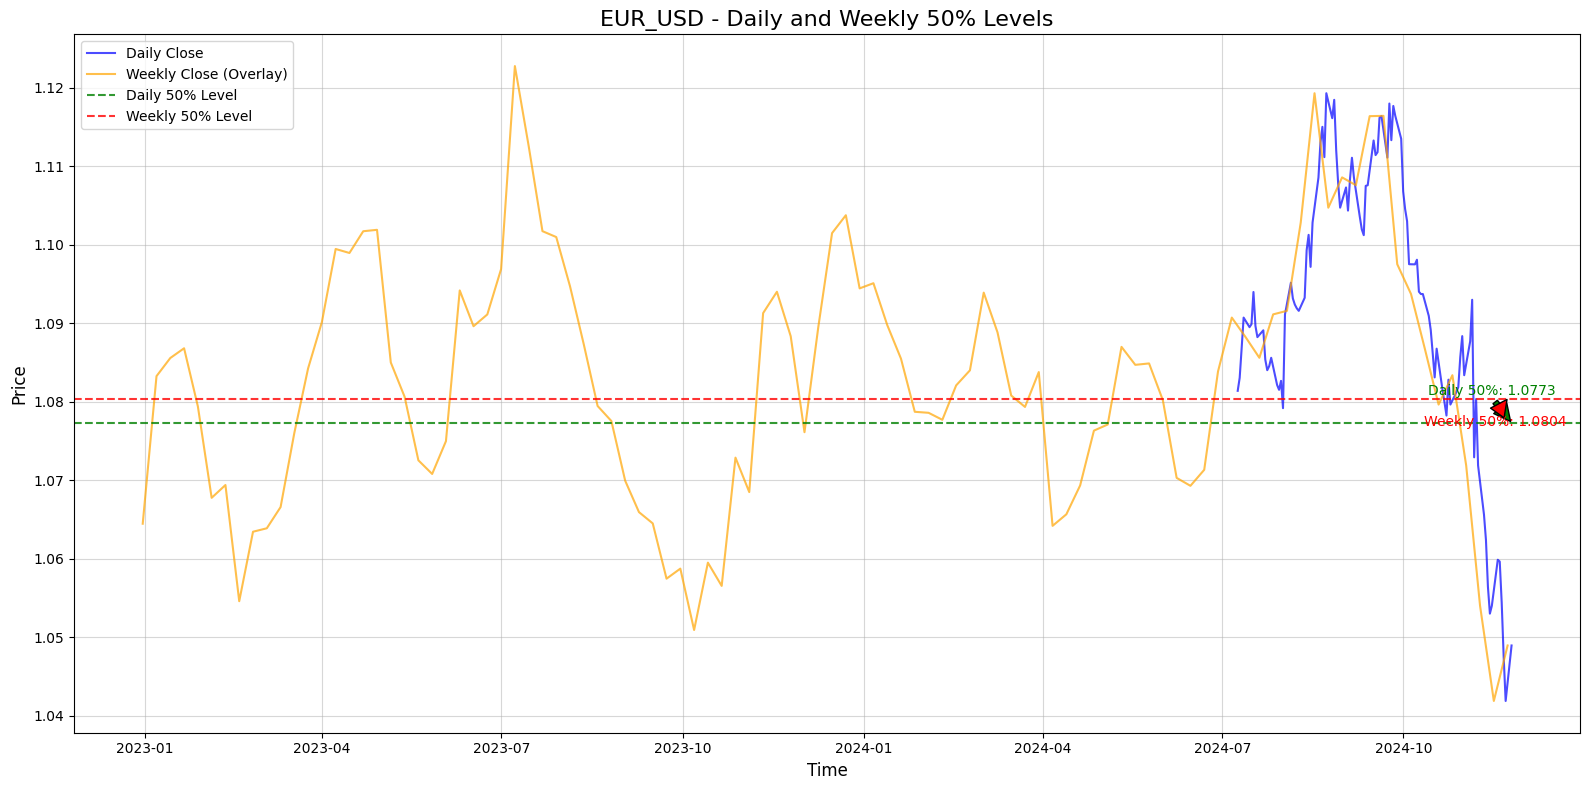

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from datetime import datetime, timedelta

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

def fetch_price_data(instrument, granularity, count=100):
    """
    Fetch historical price data from OANDA API.
    """
    params = {"granularity": granularity, "count": count}
    candles_request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    client.request(candles_request)
    candles = candles_request.response["candles"]

    # Convert data to DataFrame
    records = [
        {
            "time": candle["time"],
            "open": float(candle["mid"]["o"]),
            "high": float(candle["mid"]["h"]),
            "low": float(candle["mid"]["l"]),
            "close": float(candle["mid"]["c"])
        }
        for candle in candles
    ]
    df = pd.DataFrame(records)
    df["time"] = pd.to_datetime(df["time"])
    return df

def calculate_50_percent_levels(df):
    """
    Calculate the 50% retracement level (midpoint) based on high and low values.
    """
    high = df['high'].max()
    low = df['low'].min()
    midpoint = (high + low) / 2
    return high, low, midpoint

def plot_with_50_percent_levels(daily_df, weekly_df, daily_mid, weekly_mid, instrument):
    """
    Plot price data with 50% retracement levels for daily and weekly timeframes.
    """
    plt.figure(figsize=(16, 8))

    # Daily Prices
    plt.plot(daily_df['time'], daily_df['close'], label="Daily Close", color="blue", alpha=0.7)

    # Weekly Prices (Overlay)
    plt.plot(weekly_df['time'], weekly_df['close'], label="Weekly Close (Overlay)", color="orange", alpha=0.7)

    # Horizontal Lines for 50% Levels
    plt.axhline(daily_mid, color="green", linestyle="--", label="Daily 50% Level", alpha=0.8)
    plt.axhline(weekly_mid, color="red", linestyle="--", label="Weekly 50% Level", alpha=0.8)

    # Annotations for High, Low, and Midpoints
    plt.annotate(f"Daily 50%: {daily_mid:.4f}", xy=(daily_df['time'].iloc[-1], daily_mid),
                 xytext=(-60, 20), textcoords="offset points", color="green",
                 arrowprops=dict(facecolor="green", shrink=0.05))
    plt.annotate(f"Weekly 50%: {weekly_mid:.4f}", xy=(weekly_df['time'].iloc[-1], weekly_mid),
                 xytext=(-60, -20), textcoords="offset points", color="red",
                 arrowprops=dict(facecolor="red", shrink=0.05))

    plt.title(f"{instrument} - Daily and Weekly 50% Levels", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Instrument to analyze
    INSTRUMENT = "EUR_USD"

    # Fetch Daily and Weekly Data
    print("Fetching Daily Data...")
    daily_data = fetch_price_data(INSTRUMENT, granularity="D", count=100)

    print("Fetching Weekly Data...")
    weekly_data = fetch_price_data(INSTRUMENT, granularity="W", count=100)

    # Calculate 50% levels
    daily_high, daily_low, daily_mid = calculate_50_percent_levels(daily_data)
    weekly_high, weekly_low, weekly_mid = calculate_50_percent_levels(weekly_data)

    print(f"Daily 50% Level: {daily_mid}")
    print(f"Weekly 50% Level: {weekly_mid}")

    # Plot data with 50% levels
    plot_with_50_percent_levels(daily_data, weekly_data, daily_mid, weekly_mid, INSTRUMENT)



Processing EUR_USD...
EUR_USD - Daily 50% Level: 1.0773, Weekly 50% Level: 1.0804


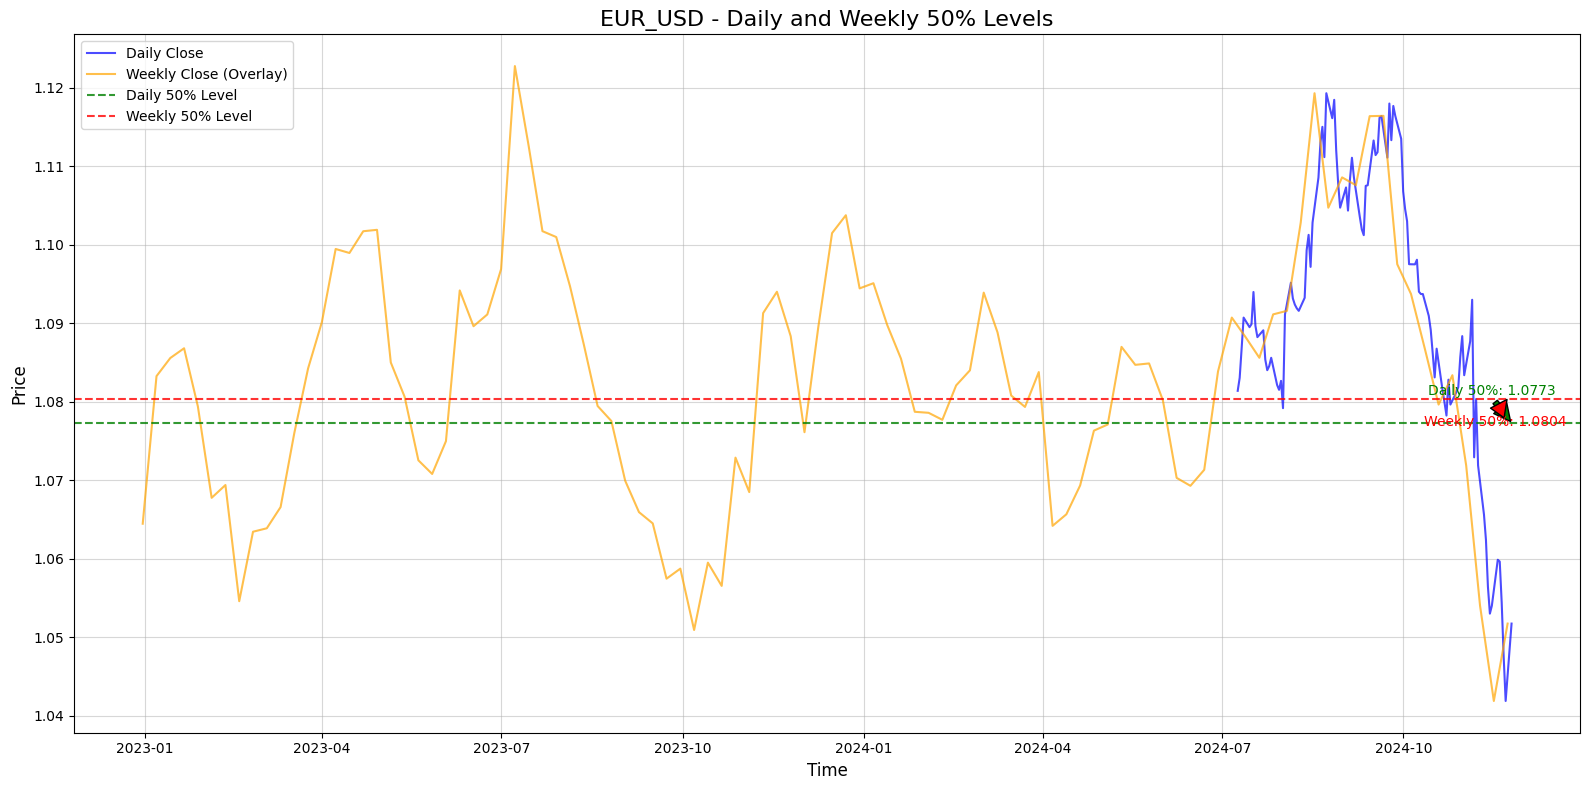


Processing GBP_USD...
GBP_USD - Daily 50% Level: 1.2961, Weekly 50% Level: 1.2619


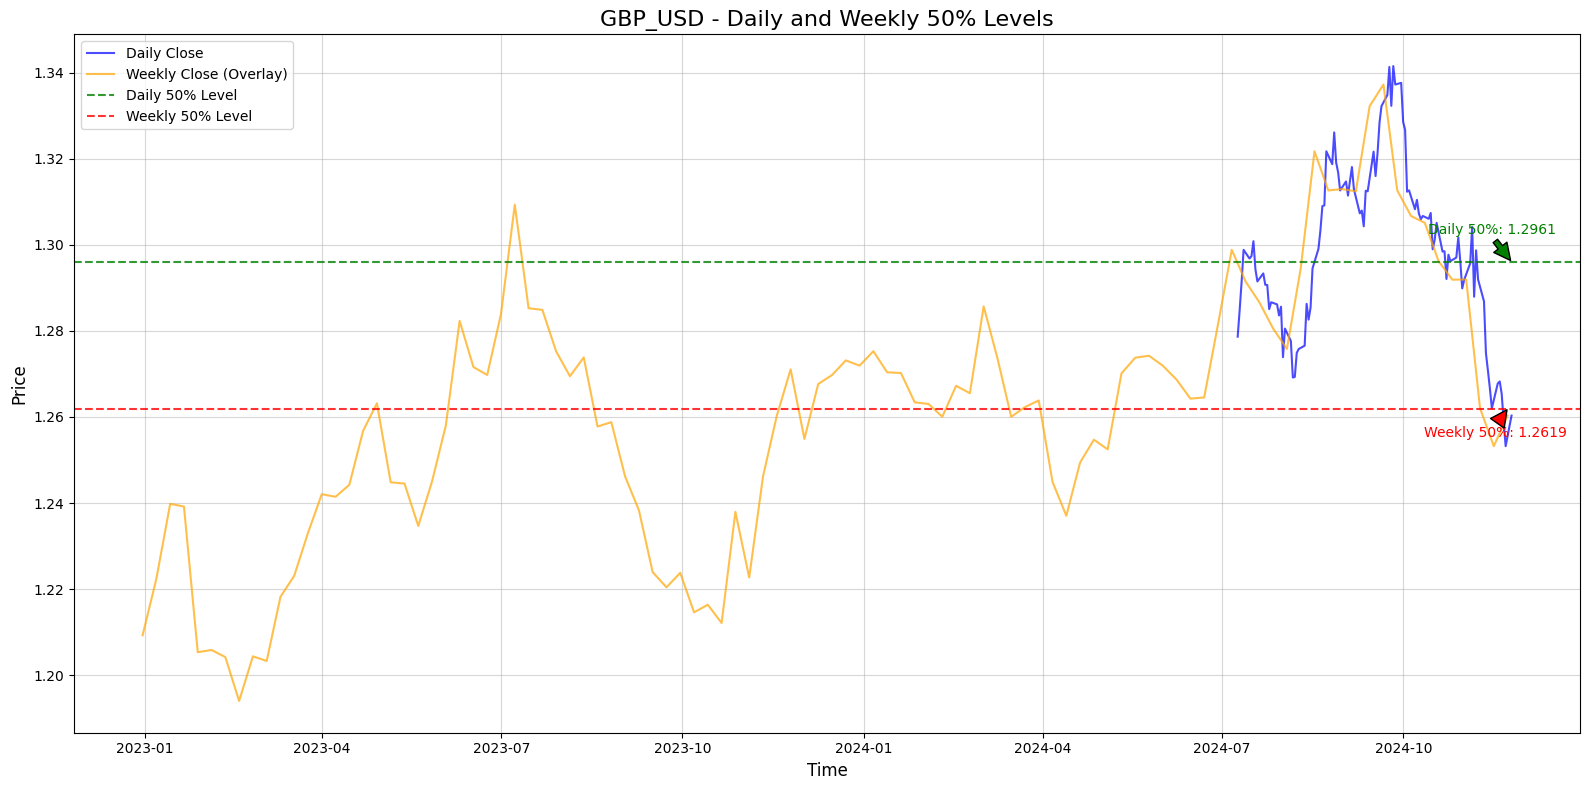


Processing USD_JPY...
USD_JPY - Daily 50% Level: 150.6935, Weekly 50% Level: 144.5850


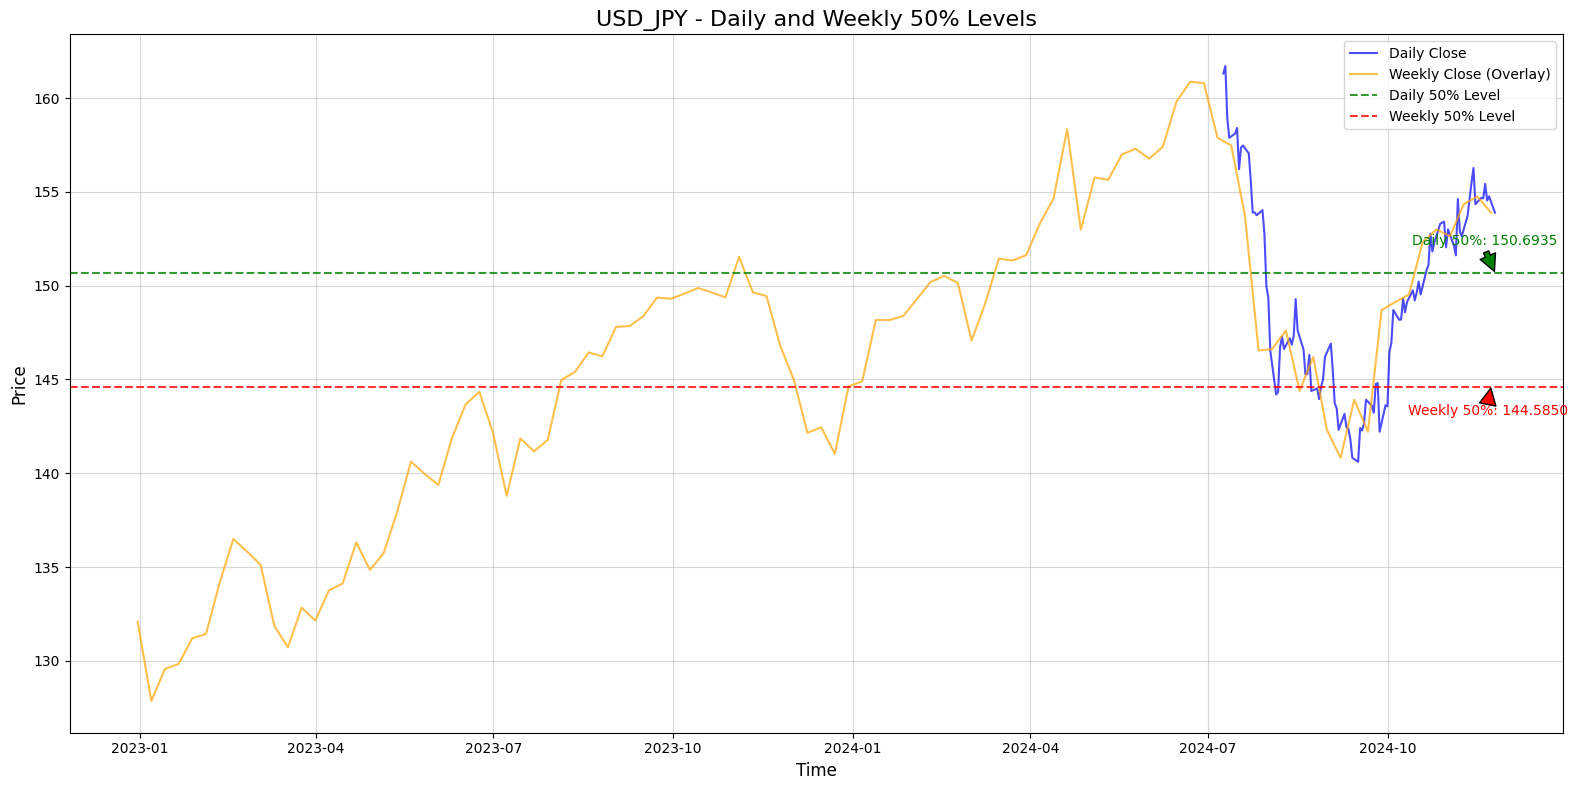


Processing AUD_USD...
AUD_USD - Daily 50% Level: 0.6645, Weekly 50% Level: 0.6714


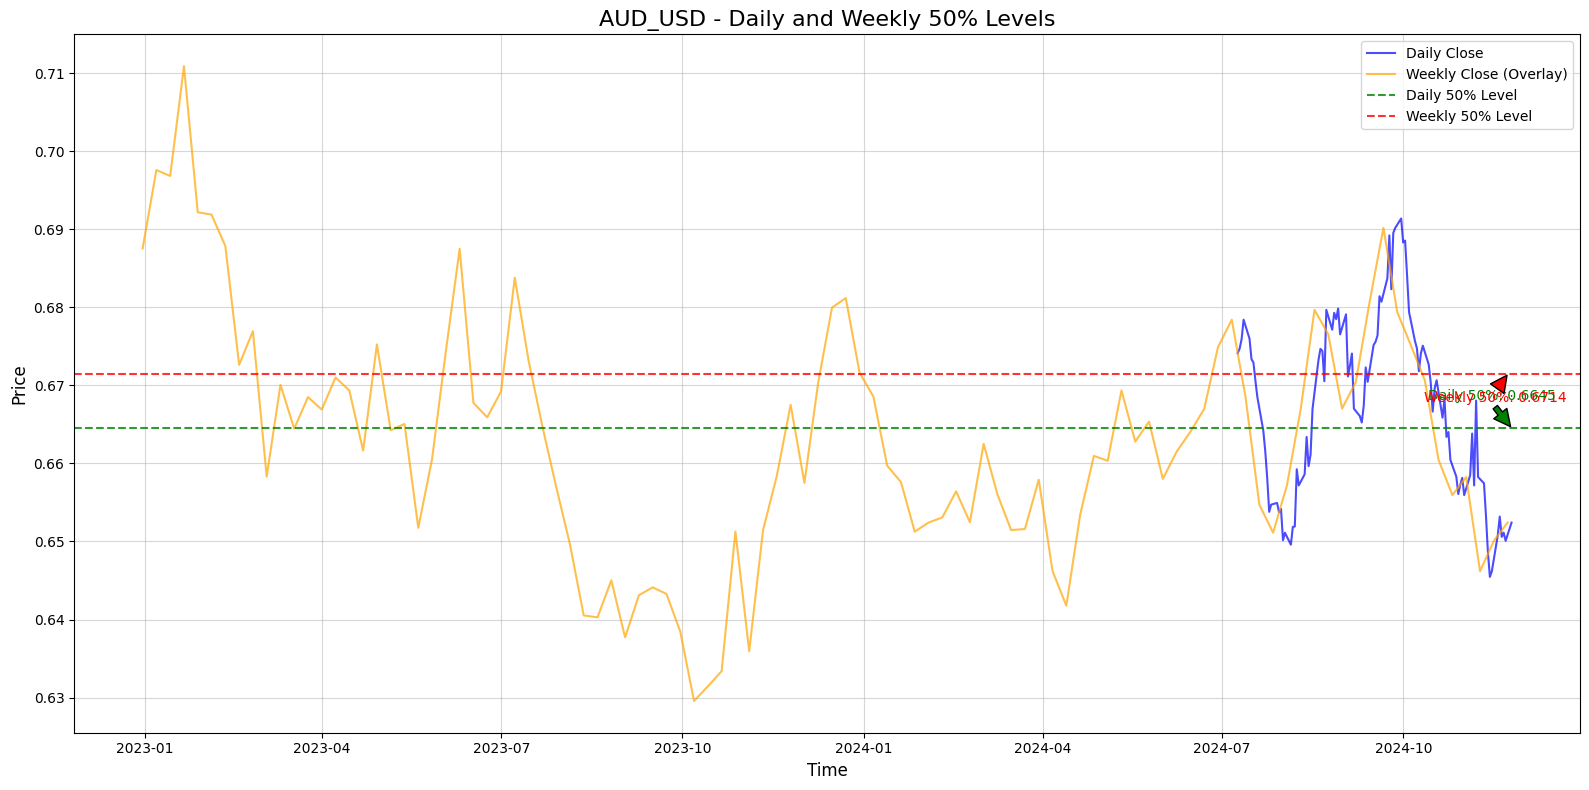


Processing USD_CHF...
USD_CHF - Daily 50% Level: 0.8688, Weekly 50% Level: 0.8886


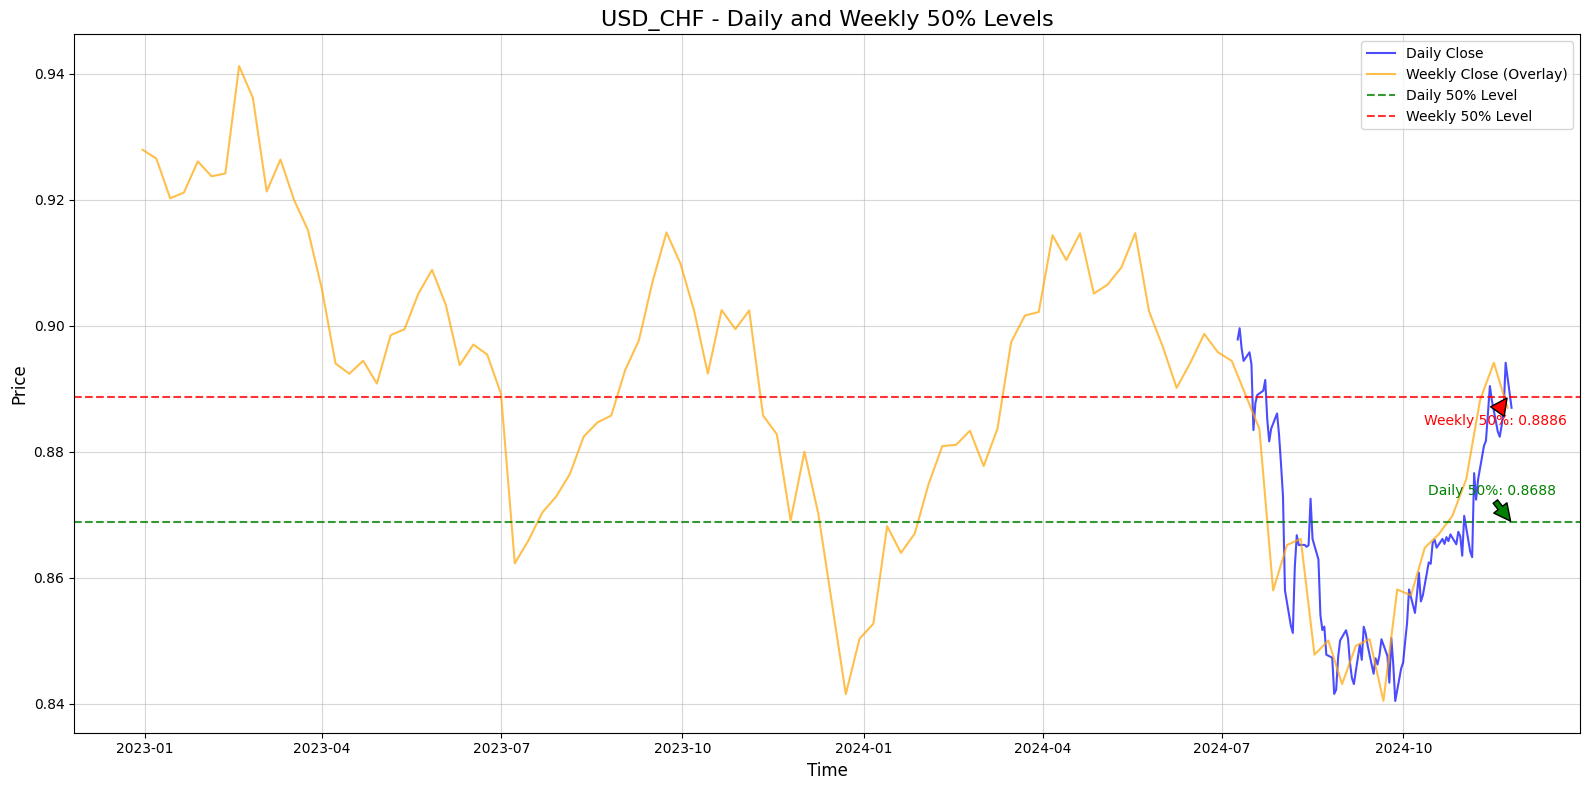


Processing USD_CAD...
USD_CAD - Daily 50% Level: 1.3763, Weekly 50% Level: 1.3599


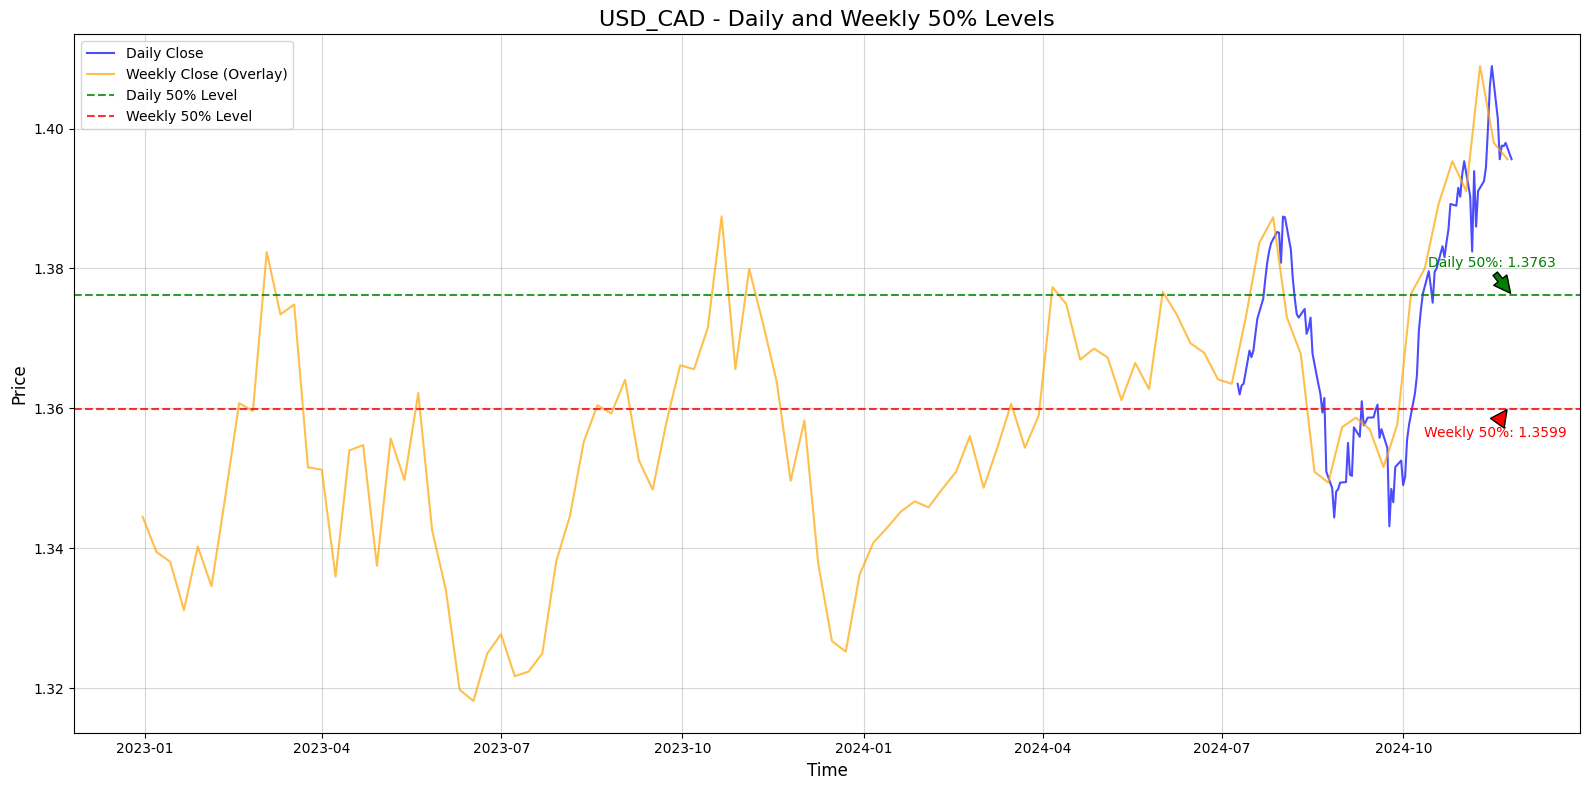


Processing NZD_USD...
NZD_USD - Daily 50% Level: 0.6098, Weekly 50% Level: 0.6156


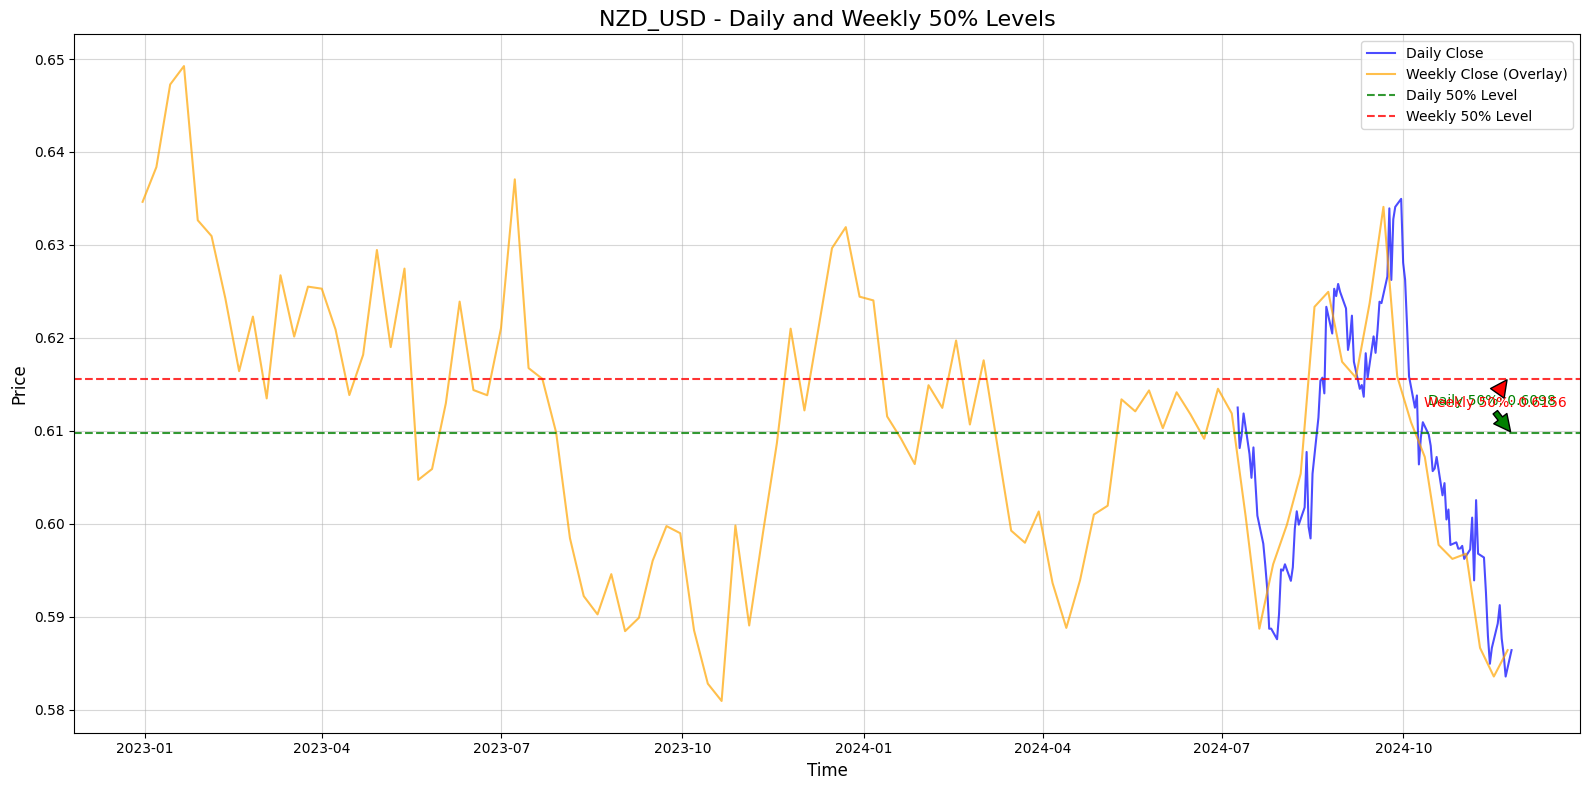

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oandapyV20
import oandapyV20.endpoints.instruments as instruments

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# List of Major Currency Pairs
CURRENCY_PAIRS = ["EUR_USD", "GBP_USD", "USD_JPY", "AUD_USD", "USD_CHF", "USD_CAD", "NZD_USD"]

def fetch_price_data(instrument, granularity, count=100):
    """
    Fetch historical price data from OANDA API.
    """
    params = {"granularity": granularity, "count": count}
    candles_request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    client.request(candles_request)
    candles = candles_request.response["candles"]

    # Convert data to DataFrame
    records = [
        {
            "time": candle["time"],
            "open": float(candle["mid"]["o"]),
            "high": float(candle["mid"]["h"]),
            "low": float(candle["mid"]["l"]),
            "close": float(candle["mid"]["c"])
        }
        for candle in candles
    ]
    df = pd.DataFrame(records)
    df["time"] = pd.to_datetime(df["time"])
    return df

def calculate_50_percent_levels(df):
    """
    Calculate the 50% retracement level (midpoint) based on high and low values.
    """
    high = df['high'].max()
    low = df['low'].min()
    midpoint = (high + low) / 2
    return high, low, midpoint

def plot_with_50_percent_levels(daily_df, weekly_df, daily_mid, weekly_mid, instrument):
    """
    Plot price data with 50% retracement levels for daily and weekly timeframes.
    """
    plt.figure(figsize=(16, 8))

    # Daily Prices
    plt.plot(daily_df['time'], daily_df['close'], label="Daily Close", color="blue", alpha=0.7)

    # Weekly Prices (Overlay)
    plt.plot(weekly_df['time'], weekly_df['close'], label="Weekly Close (Overlay)", color="orange", alpha=0.7)

    # Horizontal Lines for 50% Levels
    plt.axhline(daily_mid, color="green", linestyle="--", label="Daily 50% Level", alpha=0.8)
    plt.axhline(weekly_mid, color="red", linestyle="--", label="Weekly 50% Level", alpha=0.8)

    # Annotations for High, Low, and Midpoints
    plt.annotate(f"Daily 50%: {daily_mid:.4f}", xy=(daily_df['time'].iloc[-1], daily_mid),
                 xytext=(-60, 20), textcoords="offset points", color="green",
                 arrowprops=dict(facecolor="green", shrink=0.05))
    plt.annotate(f"Weekly 50%: {weekly_mid:.4f}", xy=(weekly_df['time'].iloc[-1], weekly_mid),
                 xytext=(-60, -20), textcoords="offset points", color="red",
                 arrowprops=dict(facecolor="red", shrink=0.05))

    plt.title(f"{instrument} - Daily and Weekly 50% Levels", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    for instrument in CURRENCY_PAIRS:
        print(f"\nProcessing {instrument}...")

        # Fetch Daily and Weekly Data
        daily_data = fetch_price_data(instrument, granularity="D", count=100)
        weekly_data = fetch_price_data(instrument, granularity="W", count=100)

        # Calculate 50% levels
        daily_high, daily_low, daily_mid = calculate_50_percent_levels(daily_data)
        weekly_high, weekly_low, weekly_mid = calculate_50_percent_levels(weekly_data)

        print(f"{instrument} - Daily 50% Level: {daily_mid:.4f}, Weekly 50% Level: {weekly_mid:.4f}")

        # Plot data with 50% levels
        plot_with_50_percent_levels(daily_data, weekly_data, daily_mid, weekly_mid, instrument)
